# Imports

In [1]:
%matplotlib inline

import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


import time
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import json
import pickle

torch.manual_seed(42)
np.random.seed(42)

In [2]:
def plot_image(image, title="image", grayscale=False, axis=False):
    axis_toggle = "off" if not axis else "on"
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(10,10))
    if not grayscale:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis(axis_toggle)

# Age dataset iterable

In [4]:
class AgeDataset(Dataset):
    # image_paths: list of image paths as strings
    # labels: list of labels as integers
    # resize: (channels, width, height) new image shape
    def __init__(self, image_paths, labels, resize=None, augmentations=None):
        self.num_samples = len(image_paths)
        self.image_paths = image_paths
        self.transform = augmentations
        self.labels = labels

        self.resize = resize
        if resize is not None:
            resize = list(resize)
            self.resize = [resize[x] for x in (1,2,0)]


    def __len__(self):
        return self.num_samples


    def __getitem__(self, item):
        image = Image.open(self.image_paths[item])
        image = image.convert("RGB")
        label = self.labels[item]

        if self.resize is not None:
            image = image.resize(
                (self.resize[1], self.resize[0]), resample=Image.BILINEAR
            )

        image = np.array(image)
        if self.transform:
            image = self.transform(image)

        # transpose from 32x32x3 to 3x32x32
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        return image, label

# Get labels out of image names

000002.jpg


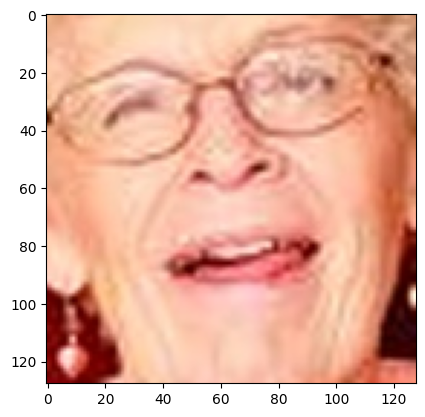

(128, 128, 3)


In [5]:
base_dir = "../data/processed/all_images"

img_path = os.listdir(base_dir)[0]
print(img_path)

img = Image.open(os.path.join(base_dir, img_path))

plt.imshow(img)
plt.show()
img = np.array(img.convert("RGB"))
print(img.shape)

In [6]:
with open('age_intervals_one.json') as f:
    current_config = json.load(f)
print(current_config)

{'0': [6, 15], '1': [16, 25], '2': [26, 35], '3': [36, 50], '4': [51, 65], '5': [66, 120]}


In [7]:
def create_label_dict(config):
    label_dict = {}
    for label, age_interval in config.items():
        age_interval = list(age_interval)
        age_interval[1] += 1
        for age in range(*age_interval):
            label_dict[age] = int(label)

    return label_dict

age_to_label = create_label_dict(current_config)
print(age_to_label)

{6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 3, 37: 3, 38: 3, 39: 3, 40: 3, 41: 3, 42: 3, 43: 3, 44: 3, 45: 3, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 4, 52: 4, 53: 4, 54: 4, 55: 4, 56: 4, 57: 4, 58: 4, 59: 4, 60: 4, 61: 4, 62: 4, 63: 4, 64: 4, 65: 4, 66: 5, 67: 5, 68: 5, 69: 5, 70: 5, 71: 5, 72: 5, 73: 5, 74: 5, 75: 5, 76: 5, 77: 5, 78: 5, 79: 5, 80: 5, 81: 5, 82: 5, 83: 5, 84: 5, 85: 5, 86: 5, 87: 5, 88: 5, 89: 5, 90: 5, 91: 5, 92: 5, 93: 5, 94: 5, 95: 5, 96: 5, 97: 5, 98: 5, 99: 5, 100: 5, 101: 5, 102: 5, 103: 5, 104: 5, 105: 5, 106: 5, 107: 5, 108: 5, 109: 5, 110: 5, 111: 5, 112: 5, 113: 5, 114: 5, 115: 5, 116: 5, 117: 5, 118: 5, 119: 5, 120: 5}


# Importing initial train and test split, as well as the pandas dataframe.

In [8]:
with open('initial_splits_binary.json') as f:
    initial_splits = json.load(f)

with open('dataframe.pkl', 'rb') as f:
    df = pickle.load(f)

df = df.drop(columns=['hog_features'])
print(df)

                              name  age
0                       000002.jpg   80
1                       000003.jpg   50
2                       000004.jpg   17
3                       000005.jpg   27
4                       000006.jpg   24
...                            ...  ...
26846  9_1_0_20170110224621441.jpg    9
26847  9_1_0_20170117172655681.jpg    9
26848  9_1_0_20170117180006484.jpg    9
26849  9_1_1_20170109201837354.jpg    9
26850  9_1_1_20170117105556810.jpg    9

[26851 rows x 2 columns]


# Create train test split using the fold dictionaries and df created above.

In [13]:
# for the network we defined, same as CIFAR10 data that we prev loaded
IMAGE_SHAPE = (3, 64, 64)
CHANNELS, WIDTH, HEIGHT = IMAGE_SHAPE

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_indices = initial_splits['train']
test_indices = initial_splits['test']

X_train = [os.path.join(base_dir, df['name'][idx]) for idx in train_indices]
y_train = [age_to_label[df['age'][idx]] for idx in train_indices]
X_test = [os.path.join(base_dir, df['name'][idx]) for idx in test_indices]
y_test = [age_to_label[df['age'][idx]] for idx in test_indices]

trainset = AgeDataset(
    image_paths=X_train,
    labels=y_train,
    resize=IMAGE_SHAPE,
)

testset = AgeDataset(
    image_paths=X_test,
    labels=y_test,
    resize=IMAGE_SHAPE,
)

In [14]:
classes = [str(x) for x in current_config.values()]
print(classes)

def convert_to_image_format(image):
    # first convert back to [0,1] range from [-1,1] range - approximately...
    image = image
    image = image.numpy()

    # from 3xWxH to WxHx3
    return image.transpose(1,2,0).astype(int)

['[6, 15]', '[16, 25]', '[26, 35]', '[36, 50]', '[51, 65]', '[66, 120]']


Shape of images: torch.Size([3, 64, 64])


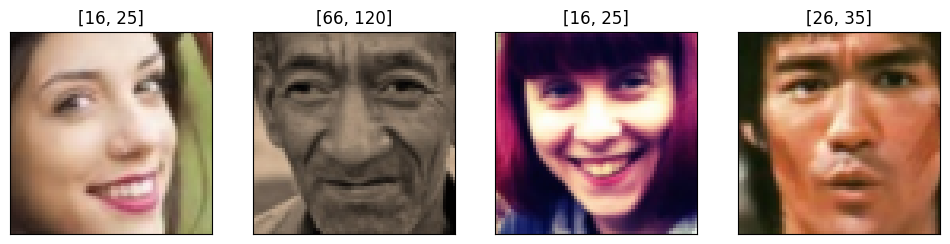

In [15]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False)

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f"Shape of images: {images[0].shape}")

fig, axes = plt.subplots(1, len(images), figsize=(12,10))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_image_format(image))
    axes[idx].set_title(classes[int(labels[idx])])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

## Function to calculate the accuracy and return a confusion matrix. Also, a simple CNN with 2 convolutional layeres.

In [16]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([len(classes),len(classes)], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            # import pdb; pdb.set_trace()
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [98]:
for epoch in range(10):  # loop over the dataset multiple times
    epoch_time = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # Transfer inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 300 == 0:    # print every 300 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 300:.3f}')
        #     running_loss = 0.0
    
    
    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)
    
print('Finished Training')

Epoch: 0 | Loss: 1.6197 | Training accuracy: 33.529% | Test accuracy: 33.532% | Epoch Time: 63.98 secs
Epoch: 1 | Loss: 1.5848 | Training accuracy: 36.136% | Test accuracy: 35.636% | Epoch Time: 63.59 secs
Epoch: 2 | Loss: 1.6050 | Training accuracy: 36.034% | Test accuracy: 36.213% | Epoch Time: 64.08 secs
Epoch: 3 | Loss: 1.5630 | Training accuracy: 34.348% | Test accuracy: 34.463% | Epoch Time: 63.78 secs
Epoch: 4 | Loss: 1.5717 | Training accuracy: 36.858% | Test accuracy: 34.630% | Epoch Time: 64.03 secs
Epoch: 5 | Loss: 1.5721 | Training accuracy: 35.042% | Test accuracy: 35.394% | Epoch Time: 63.43 secs
Epoch: 6 | Loss: 1.5565 | Training accuracy: 37.053% | Test accuracy: 35.859% | Epoch Time: 66.80 secs
Epoch: 7 | Loss: 1.5686 | Training accuracy: 34.395% | Test accuracy: 34.481% | Epoch Time: 67.25 secs
Epoch: 8 | Loss: 1.5784 | Training accuracy: 31.872% | Test accuracy: 32.340% | Epoch Time: 63.74 secs
Epoch: 9 | Loss: 1.5609 | Training accuracy: 36.434% | Test accuracy: 35.

In [102]:
os.makedirs('./CNNs', exist_ok=True)
save_path = './CNNs/cifar_simple_cnn.pth'
torch.save(model.state_dict(), save_path)

In [103]:
model = SimpleCNN()
model.load_state_dict(torch.load(save_path))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testset)} test images: {100 * correct // total} %')

Accuracy of the network on the 5371 test images: 35 %


In [123]:
# define pre-processing steps on the images
# also called "data augementation" (only done for the train set)

# transform_train = transforms.Compose([
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
#     transforms.RandomRotation(degrees=15),  # Randomly rotate images by up to 15 degrees
#     # transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Randomly crop and resize
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate
#     transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Apply perspective transformation
#     transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Randomly erase parts of the image
#     transforms.GaussianBlur(kernel_size=3),  # Apply Gaussian blur
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# # Normalize the test set same as training set without augmentation
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

In [17]:
class BaselineCNN(nn.Module):
    """Baseline CNN"""

    def __init__(self):
        """CNN Builder."""
        super(BaselineCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(16384, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, len(classes))
        )


    def forward(self, x):
        """Perform forward."""

        # conv layers
        x = self.conv_layer(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)

        return x

In [18]:
# calculating the output size of the convolutional layers, before the FC layers
dummy_input = torch.zeros([1, 3, 64, 64])
dummy_model = BaselineCNN()
dummy_output = dummy_model.conv_layer(dummy_input)
print(dummy_output.shape)
dummy_output = dummy_output.view(dummy_output.size(0), -1)
print(dummy_output.shape)
# calculating the number of trainable weights
num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
print("num trainable weights: ", num_trainable_params)

torch.Size([1, 256, 8, 8])
torch.Size([1, 16384])
num trainable weights:  18433030


In [20]:
# time to train our model
# hyper-parameters
batch_size = 32
learning_rate = 1e-4
epochs = 20

IMAGE_SHAPE = (3, 64, 64)
CHANNELS, WIDTH, HEIGHT = IMAGE_SHAPE

trainset = AgeDataset(
    image_paths=X_train,
    labels=y_train,
    resize=IMAGE_SHAPE,
)

testset = AgeDataset(
    image_paths=X_test,
    labels=y_test,
    resize=IMAGE_SHAPE,
)

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# build our model and send it to the device
model = BaselineCNN().to(device) # no need for parameters as we alredy defined them in the class

# optimizer - SGD, Adam, RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [125]:
# training loop
loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(1, epochs + 1):
    model.train()  # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)

    loss_list.append(running_loss)
    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)

    # save model
    # if epoch % 20 == 0:
    print('==> Saving model ...')
    state = {
        'net': model.state_dict(),
        'epoch': epoch,
    }
    if not os.path.isdir('./CNNs/checkpoints'):
        os.mkdir('./CNNs/checkpoints')
    torch.save(state, f'/content/checkpoints/baseline_cnn_64x64_ckpt_epoch_{epoch}.pth')

print('==> Finished Training ...')

# Plot loss, train acc vs valid acc

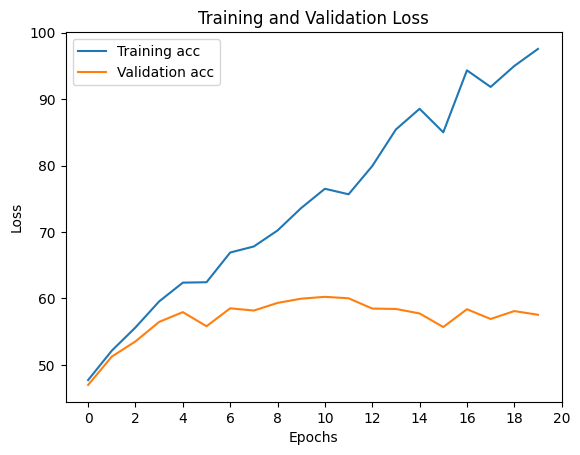

In [ ]:
# Plot and label the training and validation loss values
epochs_list = list(range(epochs))
plt.plot(epochs_list, train_acc_list, label='Training acc')
plt.plot(epochs_list, test_acc_list, label='Validation acc')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(0, 21, 2))

# Display the plot
plt.legend(loc='best')
plt.savefig(f'/content/plots/train_acc_vs_valid_acc_{EXP_COUNTER}.png')
plt.show()

test accuracy: 60.234%


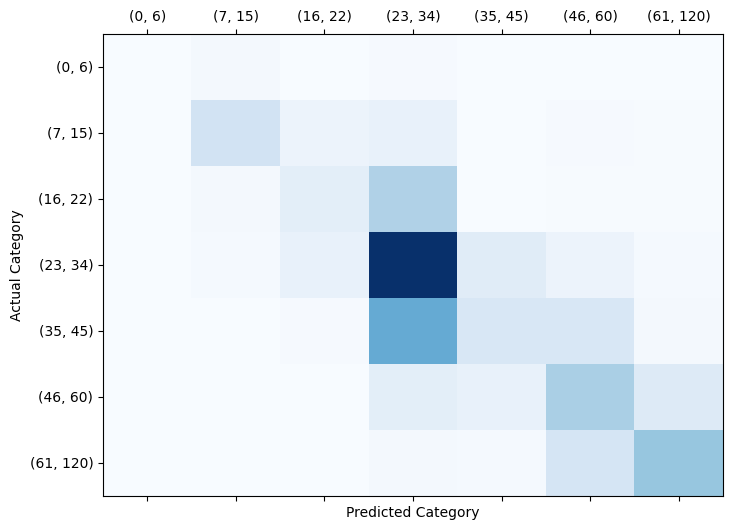

In [ ]:
# load model, calculate accuracy and confusion matrix
model = CifarCNN().to(device)
state = torch.load('/content/checkpoints/cifar_cnn_ckpt_epoch_11.pth', map_location=device)
model.load_state_dict(state['net'])

test_accuracy, confusion_matrix = calculate_accuracy(model, testloader, device)
print("test accuracy: {:.3f}%".format(test_accuracy))

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(len(classes)), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(len(classes)), classes)
plt.savefig(f'/content/plots/confusion_matrix_{EXP_COUNTER}.png')
plt.show()